In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


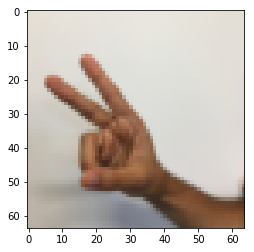

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [5]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X = tf.placeholder(name='X',shape=(None,n_H0,n_W0,n_C0),dtype=tf.float32)
    Y = tf.placeholder(name='Y',shape=(None,n_y),dtype=tf.float32)
    return X, Y

In [6]:
X,Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 6), dtype=float32)


In [24]:
def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable(name='W1',dtype=tf.float32,shape=(4, 4, 3, 8), initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable(name='W2',dtype=tf.float32,shape=(2, 2, 8, 16), initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters={'W1':W1,
                'W2':W2}
    return parameters

In [25]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))


W1 = [ 0.00131723  0.14176141 -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


In [26]:
# GRADED FUNCTION: forward_propagation
def forward_propagation(X, parameters):
    #CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(input=X, filter=W1,strides=(1,1,1,1),padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(value=A1, ksize=(1, 8, 8, 1), strides=(1, 8, 8, 1), padding='SAME')
    
    Z2 = tf.nn.conv2d(input=P1, filter=W2,strides=(1,1,1,1),padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(value=A2,ksize=(1,4,4,1),strides=(1,4,4,1),padding='SAME')
    
    P2 = tf.contrib.layers.flatten(inputs=P2)
    
    Z3 = tf.contrib.layers.fully_connected(P2,6,activation_fn=None)
    return Z3

In [27]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376  0.46852064]
 [-0.17601591 -1.57972014 -1.4737016  -2.61672091 -1.00810647  0.5747785 ]]


In [28]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost

In [33]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters =initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 2.91034


In [40]:
# GRADED FUNCTION: model
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    #CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0,n_W0,n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X,Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X,parameters)
    
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed+1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _, temp_cost = sess.run([optimizer, cost],feed_dict={X:minibatch_X, Y:minibatch_Y})
                
        
                minibatch_cost += temp_cost / num_minibatches
        
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
         # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 1.917929
Cost after epoch 5: 1.506757
Cost after epoch 10: 0.955359
Cost after epoch 15: 0.845802
Cost after epoch 20: 0.701173
Cost after epoch 25: 0.570725
Cost after epoch 30: 0.531806
Cost after epoch 35: 0.522357
Cost after epoch 40: 0.426237
Cost after epoch 45: 0.416917
Cost after epoch 50: 0.392239
Cost after epoch 55: 0.351203
Cost after epoch 60: 0.300881
Cost after epoch 65: 0.299140
Cost after epoch 70: 0.319066
Cost after epoch 75: 0.292510
Cost after epoch 80: 0.270511
Cost after epoch 85: 0.298058
Cost after epoch 90: 0.211864
Cost after epoch 95: 0.164706


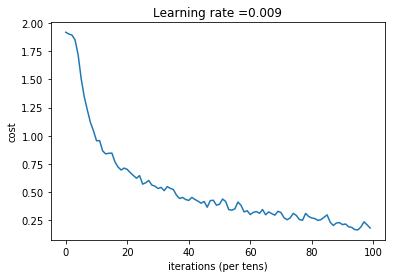

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.92963
Test Accuracy: 0.791667


In [41]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

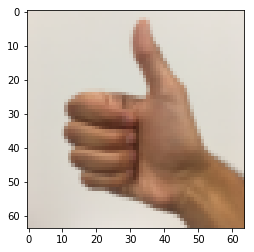

In [42]:
fname = "images/thumbs_up.jpg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)